In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim


import pickle


import matplotlib.pyplot as plt

import os
if not os.path.exists('./output/'):
    os.makedirs('./output/')


import pickle


import sys
sys.path.append("..")
import lib

sys.path.append("../scripts/")
import CA



plt.style.use(['../paper.mplstyle'])

PyTorch version: 1.7.1+cu101
Using device: cuda:0


In [3]:
# data
checkpoint_dir = '../scripts/checkpoint/'
dataset = 'maze15_half-'

single_spikes = False
bin_size = 500

dataset_tuple = CA.get_dataset(dataset)
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple
#region_edge = metainfo[0]

# model
ll_mode = 'IPPexp'
filt_mode = ''
map_mode = 'svgp64'
x_mode = 'th-pos-isi1'
z_mode = ''
hist_len = 0
folds = 5
delays = [0]
m = (ll_mode, filt_mode, map_mode, x_mode, z_mode, hist_len, folds, delays)

# load
cv_run = -1
delay = 0
batch_size = 5000


modelfit, fit_set, validation_set = lib.models.load_model(
    checkpoint_dir, m, dataset_tuple, CA.inputs_used, CA.enc_used, 
    delay, cv_run, batch_size, gpu_dev, tensor_type=torch.float, jitter=1e-5, J=100
)

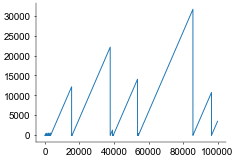

In [6]:
rcov, units_used, tbin, resamples, rc_t, max_count, bin_size, metainfo, mdl_name = dataset_tuple

plt.plot(rcov[-5][2, :100000, 0])

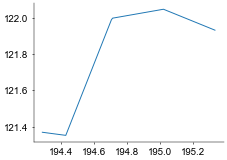

In [14]:
plt.plot(rcov[0][0, :100, 0], rcov[1][0, :100, 0])

In [15]:
steps = 1000
xp = 195.
yp = 120.
covariates = [torch.linspace(0, 2*np.pi, steps)*0, torch.ones(steps)*xp, torch.ones(steps)*yp, torch.linspace(0, 1000.0, steps)]

use_neuron = [0, 1, 2]
trials = 1

cov = modelfit.mapping.to_XZ(covariates, trials)
with torch.no_grad():
    F_mu, F_var = modelfit.mapping.compute_F(cov)


with torch.no_grad():
    modelfit.mapping.jitter = 1e-4
    mc = 10
    eps = torch.randn(mc, 17, 1000, device=modelfit.mapping.dummy.device)
    F = modelfit.mapping.sample_F(cov, eps)

In [16]:
x = torch.exp(F)
p = x*torch.exp(-torch.cumsum(x, dim=-1)*0.001)

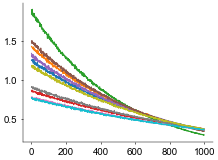

In [23]:
plt.plot(p[:, 2, :].cpu().numpy().T)
plt.show()